### Hyporheic Averaging Based on Turbidity Threshold

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import linregress

# import the data, and make first column the index 
sp_sample_SSC = pd.read_csv('spring_SSC_turbidity_SAMPLES.csv', index_col=0, parse_dates=True)
sm_sample_SSC = pd.read_csv('summer_SSC_turbidity_SAMPLES.csv', index_col=0, parse_dates=True)
sp_SSC = pd.read_csv('spring_SSC_turbidity.csv', index_col=0, parse_dates=True)
sm_SSC = pd.read_csv('summer_SSC_turbidity.csv', index_col=0, parse_dates=True)

# drop nan values 
sp_sample_SSC = sp_sample_SSC.dropna()
sm_sample_SSC = sm_sample_SSC.dropna()
sp_SSC = sp_SSC.dropna()
sm_SSC = sm_SSC.dropna()

# fixing some weird things in the summer data
sm_SSC = sm_SSC[~sm_SSC.index.duplicated(keep='first')]
sm_SSC = sm_SSC.sort_index()

# resample the data to 1 minute intervals and interpolate
sp_SSC = sp_SSC.resample('1T').interpolate()
sm_SSC = sm_SSC.resample('1T').interpolate()


#### Scatter Plots

Spring

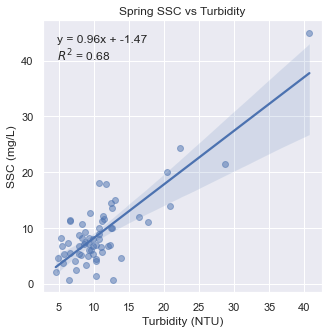

In [5]:
# calculate regression stats
x = sp_sample_SSC['Turbidity (FNU)']
y = sp_sample_SSC['SSC (mg/L)']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# scatter plot of SSC vs turbidity
sns.set(style="darkgrid") 
plt.figure(figsize=(5, 5))
sns.regplot(data=sp_sample_SSC, x='Turbidity (FNU)', y='SSC (mg/L)', 
        scatter_kws={'label': 'Spring', 'alpha': 0.5},)
# add regression equation and R² to the plot
eq_text = f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}"
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
)
plt.title('Spring SSC vs Turbidity')
plt.xlabel('Turbidity (NTU)')
plt.ylabel('SSC (mg/L)')
plt.show()


Summer

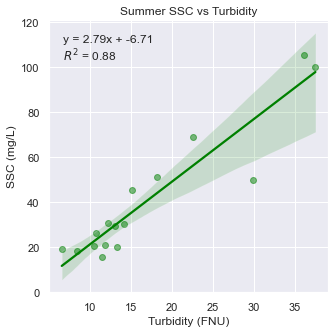

In [6]:
# calculate regression stats
x = sm_sample_SSC['Turbidity (FNU)']
y = sm_sample_SSC['SSC (mg/L)']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# scatter plot of SSC vs turbidity
sns.set(style="darkgrid") 
plt.figure(figsize=(5, 5))
sns.regplot(data=sm_sample_SSC, x='Turbidity (FNU)', y='SSC (mg/L)', 
        scatter_kws={'label': 'Spring', 'alpha': 0.5}, color='green',
        line_kws={'label': 'Spring', 'color': 'green'},)
# add regression equation and R² to the plot
eq_text = f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}"
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
)
plt.title('Summer SSC vs Turbidity')
plt.xlabel('Turbidity (FNU)')
plt.ylabel('SSC (mg/L)')
plt.show()

Note: cannot combine for a total rating curve, because turbidity units are different between seasons (FNU vs NTU)

#### Time Series

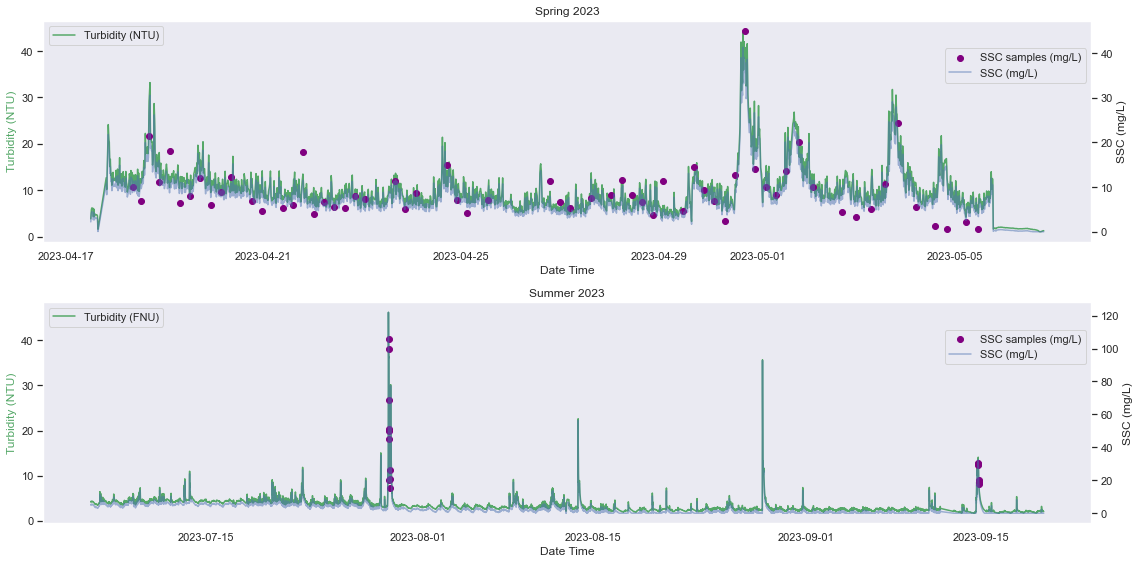

In [7]:
# plot turbidity and SSC concentration time series for both seasons 
fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

# spring
ax2 = ax1[0].twinx()  # create a second y-axis for the SSC concentration
ax1[0].plot(sp_SSC.index, sp_SSC['Turbidity (NTU)'], 'g-', label='Turbidity (NTU)')
ax2.scatter(sp_sample_SSC.index, sp_sample_SSC['SSC (mg/L)'], c='purple', marker='o', label='SSC samples (mg/L)')
ax2.plot(sp_SSC.index, sp_SSC['SSC (mg/L)'], label='SSC (mg/L)', alpha=0.5)


ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[0].set_title('Spring 2023')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax1[0].grid(False)
ax2.grid(False)

# Summer
ax2 = ax1[1].twinx()  # create a second y-axis for the SSC concentration
ax1[1].plot(sm_SSC.index, sm_SSC['Turbidity (FNU)'], 'g-', label='Turbidity (FNU)')
ax2.scatter(sm_sample_SSC.index, sm_sample_SSC['SSC (mg/L)'], c='purple', marker='o', label='SSC samples (mg/L)')
ax2.plot(sm_SSC.index, sm_SSC['SSC (mg/L)'], label='SSC (mg/L)', alpha=0.5)


ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[1].set_title('Summer 2023')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

### Calculating Turbidity Threshold

#### Percentile threshold 

Functions

In [8]:
def merge_Q_turb(df_Q: pd.DataFrame, df_T: pd.DataFrame, q_col_name: str, turb_col_name: str, how: str = "inner",):
    # checking if the columns exist in the dataframes
    if q_col_name not in df_Q.columns:
        raise KeyError(f"'{q_col_name}' not found in df_Q columns")
    if turb_col_name not in df_T.columns:
        raise KeyError(f"'{turb_col_name}' not found in df_T columns")
    # merging the dataframes
    merged = (df_Q[[q_col_name]].merge(df_T[[turb_col_name]], left_index=True, right_index=True, how=how))
    return merged

def q_cutoff_from_baseflow(merged_df: pd.DataFrame, q_col: str, baseflow_quantile: float = 0.50,): 
    # filtering the merged dataframe to get the baseflow values
    return merged_df[q_col].quantile(baseflow_quantile)

def turbidity_threshold(merged_df: pd.DataFrame, Q_cutoff: float, q_col: str, turb_col: str, percentile: float = 99.0,):
    # filtering the turbidity values based on the Q cutoff
    base_turb = merged_df.loc[merged_df[q_col] <= Q_cutoff, turb_col].dropna() 
    # calculating the percentile of the filtered turbidity values
    return np.percentile(base_turb, percentile)

Importing Discahrge Data

In [15]:
# import the discharge data
q = pd.read_csv('../../Shear Stress/stress_partitioning/discharge_2023.csv', index_col=0, parse_dates=True)

# separate the spring and summer data
q_sp = q.loc['2023-03-01':'2023-06-01']
q_sm = q.loc['2023-06-01':'2023-09-01']

Spring 

In [ ]:
# merge the spring q data with the spring turbidity data
merged_df = merge_Q_turb(q_sp, sp_SSC, q_col_name="Q", turb_col_name="Turbidity (NTU)", how="inner")

# compute Q cutoff
Q_cutoff = q_cutoff_from_baseflow(merged_df, q_col="Q", baseflow_quantile=0.50)
print(f"50th percentile of Q, which will be Q cutoff: {Q_cutoff:.2f} m3/s")

# compute critical turbidity
turb_crit = turbidity_threshold(merged_df, Q_cutoff, q_col="Q", turb_col="Turbidity (NTU)", percentile=99.0)
print(f"99th percentile of turbidity at Q cutoff: {turb_crit:.2f} NTU")

50th percentile of Q, which will be Q cutoff: 0.18 cfs
99th percentile of turbidity at Q cutoff: 14.13 NTU


Summer

In [18]:
# merge the spring q data with the spring turbidity data
merged_df = merge_Q_turb(q_sm, sm_SSC, q_col_name="Q", turb_col_name="Turbidity (FNU)", how="inner")

# compute Q cutoff
Q_cutoff = q_cutoff_from_baseflow(merged_df, q_col="Q", baseflow_quantile=0.50)
print(f"50th percentile of Q, which will be Q cutoff: {Q_cutoff:.2f} m3/s")

# compute critical turbidity
turb_crit = turbidity_threshold(merged_df, Q_cutoff, q_col="Q", turb_col="Turbidity (FNU)", percentile=99.0)
print(f"99th percentile of turbidity at Q cutoff: {turb_crit:.2f} NTU")

50th percentile of Q, which will be Q cutoff: 0.01 m3/s
99th percentile of turbidity at Q cutoff: 5.55 NTU


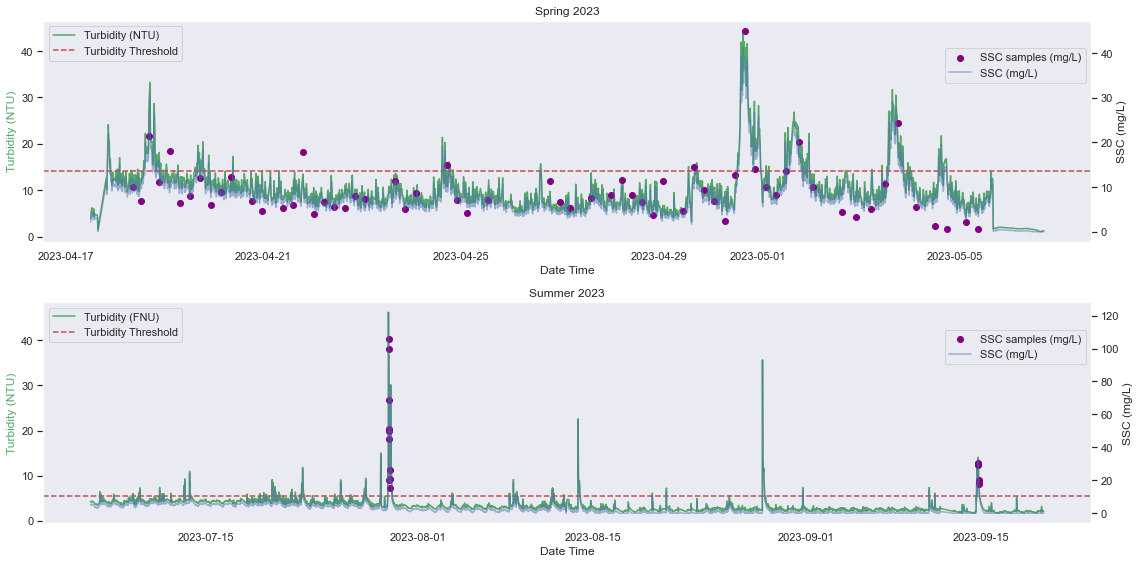

In [19]:
# plot turbidity and SSC concentration time series for both seasons 
fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

# spring
ax2 = ax1[0].twinx()  # create a second y-axis for the SSC concentration
ax1[0].plot(sp_SSC.index, sp_SSC['Turbidity (NTU)'], 'g-', label='Turbidity (NTU)')
ax2.scatter(sp_sample_SSC.index, sp_sample_SSC['SSC (mg/L)'], c='purple', marker='o', label='SSC samples (mg/L)')
ax2.plot(sp_SSC.index, sp_SSC['SSC (mg/L)'], label='SSC (mg/L)', alpha=0.5)
# add horiztonal line for turbidity threshold
ax1[0].axhline(y=14.13, color='r', linestyle='--', label='Turbidity Threshold') 

ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[0].set_title('Spring 2023')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax1[0].grid(False)
ax2.grid(False)

# Summer
ax2 = ax1[1].twinx()  # create a second y-axis for the SSC concentration
ax1[1].plot(sm_SSC.index, sm_SSC['Turbidity (FNU)'], 'g-', label='Turbidity (FNU)')
ax2.scatter(sm_sample_SSC.index, sm_sample_SSC['SSC (mg/L)'], c='purple', marker='o', label='SSC samples (mg/L)')
ax2.plot(sm_SSC.index, sm_SSC['SSC (mg/L)'], label='SSC (mg/L)', alpha=0.5)
# add horiztonal line for turbidity threshold
ax1[1].axhline(y=5.55, color='r', linestyle='--', label='Turbidity Threshold')

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[1].set_title('Summer 2023')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()